<a href="https://colab.research.google.com/github/YamenRM/NLP-Sarcasm-Detection-Project/blob/main/Sarcasm_Detection_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sarcasm Detection Models Comparison PROJECT

**1- Setup the libraries**

**2- Load & Explore Dataset**

**3. Baseline: Classical ML**

**4. Deep Learning: LSTM & GRU**

**5. Transformer: DistilBERT**

**6. Comparison Summary**

**7. Save Transformer Model**




In [16]:
# load the data file
from google.colab import files
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2 (1).json


## 1- Setup the libraries


In [17]:
# data manipulation lib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Baseline models lib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep Learning models lib
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout

# transformars lib
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset

## 2- Load & Explore Dataset

In [18]:
df=pd.read_json('Sarcasm_Headlines_Dataset_v2.json',lines=True)
print(df.head())

   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  


In [19]:
print(df.info())

print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB
None
       is_sarcastic
count  28619.000000
mean       0.476397
std        0.499451
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


In [20]:
print(df.isna().sum())
print('is duplicated :',df.duplicated().sum())

is_sarcastic    0
headline        0
article_link    0
dtype: int64
is duplicated : 2


In [21]:
# drop the duplicated
df.drop_duplicates(inplace=True)
print(df.duplicated().sum())

0


**we got a clean dataset now**

<Figure size 1500x1000 with 0 Axes>

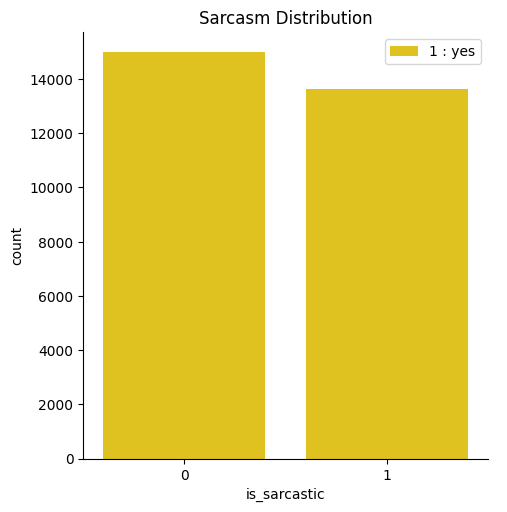

In [22]:
# label distribution
plt.figure(figsize=(15,10))
sns.catplot(x='is_sarcastic',data=df,kind='count' , color='gold')
plt.title('Sarcasm Distribution')
plt.legend(['1 : yes'])
plt.show()

**we could see that this is a balanced dataset**

In [23]:
# splitting the dataset to train/test
X_train, X_test, y_train, y_test = train_test_split(df['headline'], df['is_sarcastic'], test_size=0.2, random_state=42)

## 3. Baseline: Classical ML

In [24]:
# feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# logistic reg
logreg = LogisticRegression(max_iter=1250)
logreg.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg.predict(X_test_tfidf)

# NB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred_nb = nb.predict(X_test_tfidf)

#SVM
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)

# evaluation
models = ['Logistic Regression', 'Naive Bayes', 'SVM']
y_preds = [y_pred_logreg, y_pred_nb, y_pred_svm]
for model, y_pred in zip(models, y_preds):
    print(model)
    print(classification_report(y_test, y_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3007
           1       0.82      0.83      0.83      2717

    accuracy                           0.83      5724
   macro avg       0.83      0.83      0.83      5724
weighted avg       0.83      0.83      0.83      5724

Naive Bayes
              precision    recall  f1-score   support

           0       0.82      0.86      0.84      3007
           1       0.84      0.79      0.81      2717

    accuracy                           0.83      5724
   macro avg       0.83      0.83      0.83      5724
weighted avg       0.83      0.83      0.83      5724

SVM
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3007
           1       0.82      0.82      0.82      2717

    accuracy                           0.83      5724
   macro avg       0.83      0.83      0.83      5724
weighted avg       0.83      0.83     

## 4. Deep Learning: LSTM & GRU

In [25]:
# set the parameters for the models
max_words = 10000
max_len = 100

# set the tokenizer
tokenizer = Tokenizer(num_words=max_words , oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# convert the text to sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [26]:
# LSTM model
lstm_model = Sequential(
    [
        Embedding(max_words, 128, input_length=max_len),
        LSTM(128 , dropout=0.2 , recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ]
)

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train, batch_size=128, epochs=3, validation_data=(X_test_seq, y_test))

# classification report
y_pred_lstm = (lstm_model.predict(X_test_seq) > 0.5).astype(int)
print(classification_report(y_test, y_pred_lstm))

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.7108 - loss: 0.5341 - val_accuracy: 0.8539 - val_loss: 0.3316
Epoch 2/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.9073 - loss: 0.2367 - val_accuracy: 0.8501 - val_loss: 0.3430
Epoch 3/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 338ms/step - accuracy: 0.9368 - loss: 0.1604 - val_accuracy: 0.8461 - val_loss: 0.3669
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3007
           1       0.83      0.84      0.84      2717

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724



In [27]:
# GRU model
gru_model = Sequential(
    [
        Embedding(max_words, 128 , input_length=max_len),
        GRU(128 , dropout=0.2 , recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ]
)

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.fit(X_train_seq, y_train, batch_size=128, epochs=3, validation_data=(X_test_seq, y_test))

#classification report
y_pred_gru = (gru_model.predict(X_test_seq) > 0.5).astype(int)
print(classification_report(y_test, y_pred_gru))

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 297ms/step - accuracy: 0.6881 - loss: 0.5502 - val_accuracy: 0.8457 - val_loss: 0.3324
Epoch 2/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 302ms/step - accuracy: 0.9060 - loss: 0.2411 - val_accuracy: 0.8541 - val_loss: 0.3248
Epoch 3/3
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 300ms/step - accuracy: 0.9447 - loss: 0.1535 - val_accuracy: 0.8532 - val_loss: 0.3639
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3007
           1       0.86      0.83      0.84      2717

    accuracy                           0.85      5724
   macro avg       0.85      0.85      0.85      5724
weighted avg       0.85      0.85      0.85      5724



## 5. Transformer: DistilBERT

In [32]:
# preprocess

# Set the datasets
train_dataset= Dataset.from_dict({'text': X_train.tolist(), 'label': y_train.tolist()})
test_dataset= Dataset.from_dict({'text': X_test.tolist(), 'label': y_test.tolist()})


# set the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
  return(tokenizer(batch['text'], padding=True, truncation=True))

train_dataset=train_dataset.map(tokenize, batched=True, batch_size=len(train_dataset))
test_dataset=test_dataset.map(tokenize, batched=True, batch_size=len(test_dataset))


train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# load the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased' , num_labels=2)


# train the model
training_args = TrainingArguments(
   output_dir='./results',
   num_train_epochs=3,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=64,
   warmup_steps=500,
   weight_decay=0.01,
   logging_dir='./logs',
   logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()
trainer.evaluate()

# prediction
preds_output=trainer.predict(test_dataset)
preds=np.argmax(preds_output.predictions, axis=-1)

# classification report
print(classification_report(y_test, preds))

Map:   0%|          | 0/22893 [00:00<?, ? examples/s]

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yamenrm (yamenrm-github) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.698500
20,0.713900
30,0.698200
40,0.697900
50,0.692100
60,0.695100
70,0.674100
80,0.667600
90,0.666500
100,0.643500


              precision    recall  f1-score   support

           0       0.93      0.94      0.94      3007
           1       0.94      0.92      0.93      2717

    accuracy                           0.93      5724
   macro avg       0.93      0.93      0.93      5724
weighted avg       0.93      0.93      0.93      5724



## 6. Comparison Summary

In [51]:
# showcasing the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes', 'SVM', 'LSTM', 'GRU', 'DistilBERT'],
    'Accuracy': [accuracy_score(y_test, y_pred_logreg), accuracy_score(y_test, y_pred_nb), accuracy_score(y_test, y_pred_svm),
                 accuracy_score(y_test, y_pred_lstm), accuracy_score(y_test, y_pred_gru), accuracy_score(y_test, preds)]
})

# sorting the results
results_sort = results.sort_values(by='Accuracy', ascending=False)

# make it prsentege based
results_sort['Accuracy'] = results['Accuracy'].apply(lambda x: '{:.2%}'.format(x))

# print the results
print(results_sort)

                 Model Accuracy
5           DistilBERT   93.12%
4                  GRU   85.32%
3                 LSTM   84.61%
0  Logistic Regression   83.44%
2                  SVM   82.95%
1          Naive Bayes   82.74%


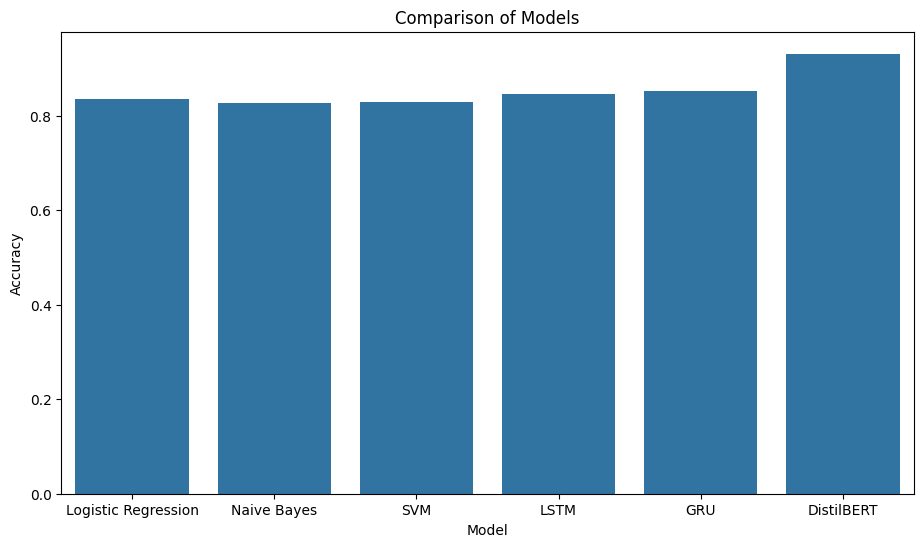

In [54]:
# Visualization
plt.figure(figsize=(11, 6))
sns.barplot(x='Model', y='Accuracy' , data=results)
plt.title('Comparison of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

### 🔍 Key Insights from the Models

#### Baseline Models (LogReg, SVM, Naive Bayes)

 - Accuracy ~82–83%

 - These models already do well for text classification when features are engineered (TF-IDF).

 - Insight → Simple linear models are strong baselines in NLP. They’re efficient and useful for comparison.

#### RNN-based Models (LSTM & GRU)

 - Accuracy ~84–85%

 - Slightly outperform baselines, showing that sequence modeling captures context better than bag-of-words.

 - Insight → But gains are relatively small considering the extra training cost. This highlights the limitations of RNNs on modern NLP benchmarks.

#### Transformers (DistilBERT)

 - Accuracy ~93% (huge jump!)

 - Shows that pretrained transformers leverage transfer learning and contextual embeddings far better than RNNs or TF-IDF.

 - Insight → Fine-tuned transformers dominate NLP tasks. The 10% jump in accuracy is transformer magic, even with fewer epochs.

## 7. Save Transformer Model

In [56]:
# saving the best model
import joblib
joblib.dump(model, 'distilbert_model.pkl')


['distilbert_model.pkl']